In [1]:
from scipy.ndimage import distance_transform_edt
from skimage.segmentation import find_boundaries
import numpy as np
import matplotlib.pyplot as plt
import torch
from train import init_data_loaders, init_datasets

In [2]:
base_dir = "."
LOCAL = True
(train_image_dir, train_images, train_mask_dir, val_images, val_percent) = (
    init_datasets(base_dir)
)

flip_prob = 0.1
rotate_prob = 0.1
elastic_prob = 0.11
translate_prob = 0.1
brightness_prob = 0.1
batch_size = 1 if LOCAL else 9
train_dataloader, val_dataloader = init_data_loaders(
    batch_size,
    brightness_prob,
    elastic_prob,
    flip_prob,
    rotate_prob,
    train_image_dir,
    train_images,
    train_mask_dir,
    translate_prob,
    val_images,
    num_workers=0,
)

In [ ]:
for images, masks in train_dataloader:
    image = images[0].permute(1, 2, 0).cpu().numpy()
    mask = masks[0].cpu().numpy().squeeze()
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(image, cmap="gray")
    axs[1].imshow(mask, cmap="gray")
    assert image.shape[:2] == (572, 572)
    assert mask.shape == (388, 388)
    plt.show()

tensor([3.9561, 1.3383]) tensor(150544)
tensor([[[[1.3383, 1.3383, 1.3383,  ..., 3.9561, 3.9561, 3.9561],
          [1.3383, 1.3383, 1.3383,  ..., 3.9561, 3.9561, 3.9561],
          [1.3383, 1.3383, 1.3383,  ..., 1.3383, 3.9561, 3.9561],
          ...,
          [1.3383, 1.3383, 1.3383,  ..., 1.3383, 1.3383, 1.3383],
          [1.3383, 1.3383, 1.3383,  ..., 1.3383, 1.3383, 1.3383],
          [1.3383, 1.3383, 1.3383,  ..., 1.3383, 1.3383, 1.3383]]]])


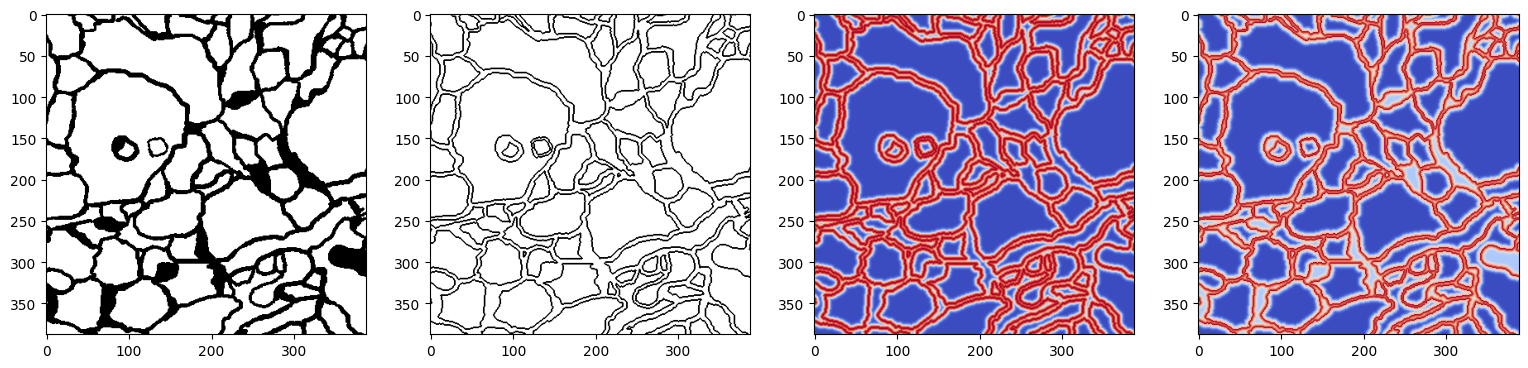

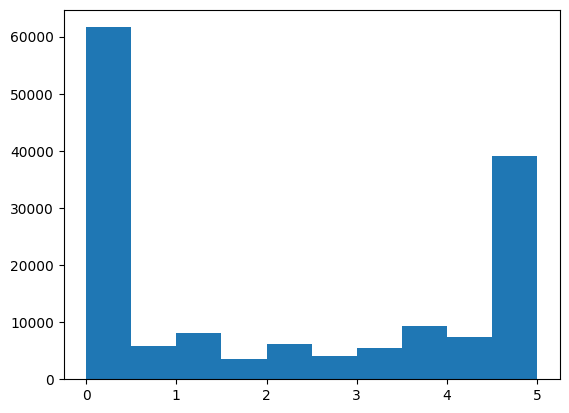

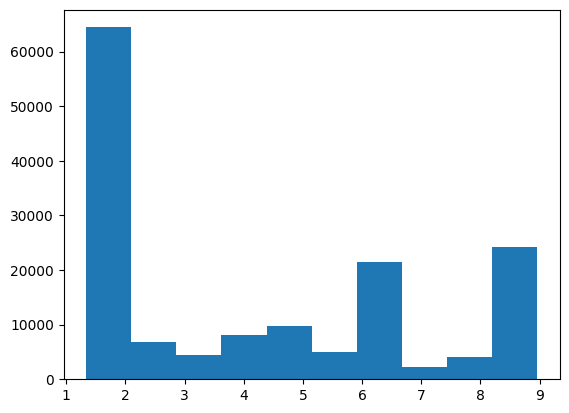

In [4]:
W0, SIGMA = 5, 5
for images, labels in train_dataloader:
    borders = find_boundaries(labels)
    dist = distance_transform_edt(~borders)
    w = W0 * np.exp(-2 * dist**2 / SIGMA**2)

    labels_bincount = torch.bincount(labels.flatten())
    w_class = labels_bincount.sum() / labels_bincount
    print(w_class, labels_bincount.sum())

    class_map = w_class[labels]
    print(class_map)

    w_final = class_map.numpy() + w

    fig, axs = plt.subplots(1, 4, figsize=(19, 6))
    axs[0].imshow(labels.squeeze(), cmap="gray")
    axs[1].imshow(~borders.squeeze(), cmap="gray")
    axs[2].imshow(w.squeeze(), cmap="coolwarm")
    axs[3].imshow(w_final.squeeze(), cmap="coolwarm")
    plt.show()
    plt.hist(w.flatten(), bins=10)
    plt.show()
    plt.hist(w_final.flatten(), bins=10)
    break